In [ ]:
## Install and load packages ======================================================
!apt install libspatialindex-dev
!pip3 install osmnx
import numpy as np
import pandas as pd
import seaborn as sns
# !pip uninstall matplotlib
# !pip install matplotlib==3.1.3
import matplotlib.pyplot as plt
import IPython.display as disp
import osmnx as ox
import networkx as nx
from datetime import timedelta
from shapely.geometry import Polygon, LineString, Point
import itertools as iter

!pip3 install geneticalgorithm
from geneticalgorithm import geneticalgorithm as ga
import math
%matplotlib inline
ox.config(log_console=True)
ox.__version__

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c6 libspatialindex6
The following NEW packages will be installed:
  libspatialindex-c6 libspatialindex-dev libspatialindex6
0 upgraded, 3 newly installed, 0 to remove and 9 not upgraded.
Need to get 319 kB of archives.
After this operation, 1,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libspatialindex6 amd64 1.9.3-2 [247 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libspatialindex-c6 amd64 1.9.3-2 [55.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libspatialindex-dev amd64 1.9.3-2 [16.0 kB]
Fetched 319 kB in 2s (190 kB/s)
Selecting previously unselected package libspatialindex6:amd64.
(Reading database ... 120880 files and directories currently installed.)
Preparing to unpack .../libspatialindex6_1.9.3-2_amd64.deb ...
Unpa

<ipython-input-1-daf75fdac4a0>:21: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(log_console=True)


'1.7.1'

In [ ]:
#mount my google drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Useful  Function

In [ ]:
def get_amenities_dataframe(place="San Juan, Batangas, Philippines", tags={"amenity": ["hospital", "school", "kindergarten", "college", "university"]}):
    """
    Automated extraction of schools and hospitals.

    Args:
    - place (str): String specifying the location.
    - tags (dict): Dictionary specifying OSM tags to filter amenities.

    Returns:
    - pd.DataFrame: DataFrame containing information about the specified amenities within the specified geographic place.
    """
    df = ox.geometries_from_place(place, tags)
    df["latlong"] = df.geometry.centroid
    df.reset_index(level=0, inplace=True)
    return df

In [ ]:
def Lsite_optimization(vacc, vill,
                       L = 3, graph_area = ("San Juan, Batangas, Philippines"),
                        distance = "road", return_distances = False, enumerative = False):
  '''
  @vacc =   Vaccination centers dataframe
  @villages =  Village centers dataframe
  @L =  number of vaccination sites to be used for optimization
  graph_area = string of the region name
  distance = string of the distance type, can be "road", "euclidean", or 'time
  return_distances = If true, the function will return the distances matrix between each village center and each vaccination site
  enumerative = If true, every possible combination of vaccination centers will be iterated on.
                 If false, genetic algorithms will be used for speed.
  '''

  TI = vill.infected.sum()
  TP = vill.population.sum()
  vill["weight"] = vill.infected/TI + vill.population/TP

  ##  Automated N-site Optimization!!! ================================================================

  ## Select Open Street Map code for the given province

  graph_area = graph_area

  # Create the graph of the area from OSM data. It will download the data and create the graph
  G = ox.graph_from_place(graph_area, network_type='drive')
  G = ox.add_edge_speeds(G)
  G = ox.add_edge_travel_times(G)


  ## Phase 1: N-site  Distance Matrix------------------------------------------------------------------
  index = vacc.Name
  columns = vill.Village_name
  df_distances = pd.DataFrame(index=index, columns = columns)

  for i in vacc.index:
    for j in vill.index:
      if distance == "road":
        #Get pure road distance
        origin_node = ox.distance.nearest_nodes(G, Y = vill.iloc[j].latitude, X = vill.iloc[j].longitude)
        destination_node = ox.distance.nearest_nodes(G, Y = vacc.iloc[i].latitude, X = vacc.iloc[i].longitude)

        df_distances.iloc[i,j] = nx.shortest_path_length(G,
                                            origin_node, destination_node, weight='length')
      if distance == "euclidean":
        df_distances.iloc[i,j] = ox.distance.euclidean_dist_vec(
          vacc.iloc[i].latitude, vacc.iloc[i].longitude, vill.iloc[j].latitude, vacc.iloc[j].longitude)

      if distance == "time":
        #Get pure road distance
        origin_node = ox.distance.nearest_nodes(G, Y = vill.iloc[j].latitude, X = vill.iloc[j].longitude)
        destination_node = ox.distance.nearest_nodes(G, Y = vacc.iloc[i].latitude, X = vacc.iloc[i].longitude)

        df_distances.iloc[i,j] = nx.shortest_path_length(G,
                                            origin_node, destination_node, weight='travel_time')


  index1 = list(iter.combinations(df_distances.index, L))
  master = pd.DataFrame(index=index1, columns = vill.Village_name)

  print("phase 1 complete,  distance matrix computed")

  #Phase 2 ---------------------------------------------------------------------------

  if enumerative is True:
    for i, name in enumerate(list(iter.combinations(df_distances.index, L))):
        #print(i)
        for j in vill.index:
          # Get weights
          weight = vill["weight"][j]
          sads = [None]*L
          for k in np.arange(0,L):
            sads[k] = df_distances.loc[name[k]][j]
          master.iloc[i,j] = weight*min(sads)
    print("phase 2 complete, optimization finished")

    ## Display Best Vaccination centers!
    results_Lsite = pd.DataFrame(master.sum(axis=1))
    results_Lsite.columns = ["Cost"]
    if return_distances is True:
      return results_Lsite.sort_values(by=['Cost'], ascending=True), df_distances
    else:
      return results_Lsite.sort_values(by=['Cost'], ascending=True)


  else:

    ## Combinatorial Genetic Algorithm Optimization
    varbound=np.array([[0,vacc.shape[0]-1]]*L)

    master = pd.DataFrame(0, index=[0], columns=vill.Village_name)
    def f(x):
      x = x.tolist()
      for j in vill.index:
        # Get weights
        weight = vill["weight"][j]
        sads = [None]*L
        for k in np.arange(0,L):
          sads[k] = df_distances.iloc[math.ceil(x[k]),j]
        master.iloc[0,j] = weight*min(sads)
      fitness = master.sum(axis=1)[0]
      return fitness


    algorithm_param = {'max_num_iteration': 300*L,
                      'population_size': 20*(L**2),
                      'mutation_probability':0.1,
                      'elit_ratio': 0.01,
                      'crossover_probability': 0.5,
                      'parents_portion': 0.3,
                      'crossover_type':'uniform',
                      'max_iteration_without_improv': 50}


    model = ga(function= f, dimension= L, variable_type='int', variable_boundaries=varbound,
            algorithm_parameters=algorithm_param)

    print(model.run())


    ## Display Best Vaccination centers!
    results_Lsite =  [int(i) for i in model.output_dict['variable'].tolist()]
    results_Lsite = tuple(df_distances.index[results_Lsite].tolist())
    wew = {'Cost': model.output_dict['function']}
    results_Lsite = pd.DataFrame(wew, index = [results_Lsite])

    if return_distances is True:
      return results_Lsite, df_distances
    else:
      return results_Lsite

In [ ]:
def site_distribution(results, df_distances):

  ## results = results from the nsite_optimization function
  ## df_distances = distance matrix from the nsite_optimization function
    solution = df_distances.loc[[a for a in results.index[0]]]
    index = df_distances.columns
    columns = ["vaccination_center", "distance"]
    assignment  = pd.DataFrame(index=index, columns = columns)
    for i, name in enumerate(df_distances.columns):
      assignment.loc[name, "vaccination_center"] = solution.loc[:, [name]].sort_values(by=[name], ascending= True).index[0]
      assignment.loc[name, "distance"] = solution.loc[:, [name]].sort_values(by=[name], ascending=True).iloc[0, 0]

    distribution = assignment["vaccination_center"].value_counts()
    return assignment, distribution

In [ ]:
def optimal_sites(vaccination_centers_df, villages_df,
                       L,  graph_area = ("San Juan, Batangas, Philippines"), return_ranking = False, enumerative = False,
                        distance = "road", return_distances = False, plot = True):
  '''
  PARAMS:
  @vaccinatiOn_centers_df =   Vaccination centers dataframe
  @villages_df =  Village centers dataframe
  @L =  number of vaccination sites to be used for optimization
  graph_area = string of the region name
  distance = string of the distance type, can be "road", "euclidean", or 'time
  return_distances = If true, the function will return the distances matrix between each village center and each vaccination site
  enumerative = If true, every possible combination of vaccination centers will be iterated on.
                 If false, genetic algorithms will be used for speed.
  return_ranking = If true, then the results from the enumeration will be the output. This can only be done when enumerative = True.
  plot = If true then geospatial plot is shown
  '''


  vacc = vaccination_centers_df
  vill = villages_df
  TI = vill.infected.sum()
  TP = vill.population.sum()
  vill["weight"] = vill.infected/TI + vill.population/TP

  result_nsites, df_distances = Lsite_optimization(vacc = vacc, vill = vill, L = L, graph_area = graph_area,
                                                   distance = distance, return_distances = True, enumerative = enumerative)
  assignment_nsite, distribution_nsite = site_distribution(results =  result_nsites, df_distances = df_distances)


  ## Plotting!!! =================================================================================================

  #Create the graph of the area from OSM data.
  G = ox.graph_from_place(graph_area, network_type='drive')
  G = ox.add_edge_speeds(G)
  G = ox.add_edge_travel_times(G)

  ## Get coordinates of optimal sites
  optimal_sites = list(assignment_nsite.vaccination_center.unique())
  optimal_sites_loc = vacc[vacc.Name.isin(optimal_sites)]
  optimal_sites_loc["colors"] = optimal_sites_loc["Name"].astype('category').cat.codes
  optimal_sites_loc

  # Get coordinates and assignments of barangays
  wew = pd.merge(assignment_nsite, vill, on = "Village_name")
  wew["colors"] = wew["vaccination_center"].astype('category').cat.codes
  wew = wew.rename(columns={'vaccination_center': 'assigned_vaccination_center'})

  if plot is True:
      plt.figure(figsize=(25, 17), dpi=1500)
      fig, ax = ox.plot_graph(G, edge_color = None, show=False, close=False, bgcolor = "white",
                              edge_linewidth=1, node_size=1, figsize=(25, 20), dpi = 20000)

      ax.scatter(wew.longitude, wew.latitude, s= 100, c=wew["colors"], linewidths=1, edgecolors = "black", cmap='viridis')
      ax.scatter(optimal_sites_loc.longitude, optimal_sites_loc.latitude, s = 800, edgecolors = "black",
                c=optimal_sites_loc["colors"], linewidths=2, marker = "*")
      plt.style.use('Solarize_Light2')
      plt.show()


  if return_distances is True:
    if return_ranking is True:
      return assignment_nsite, df_distances, result_nsites
    else:
      return assignment_nsite, df_distances
  else:
    if return_ranking is True:
     return assignment_nsite, result_nsites
    else:
      return assignment_nsite

In [ ]:
## Alternative automated way to obtain a partial vaccinations table =============
get_amenities_dataframe(place = "Los Banos, Laguna")

<ipython-input-3-3dc1fa51a2e3>:12: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  df = ox.geometries_from_place(place, tags)
<ipython-input-3-3dc1fa51a2e3>:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df["latlong"] = df.geometry.centroid
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._boot

,element_type,geometry,barrier,alt_name,amenity,name,name:en,nodes,addr:city,addr:postcode,...,name:etymology,name:etymology:wikidata,old_name:en,old_name:tl,abbr_name,addr:barangay,addr:country,ways,type,latlong
osmid,,,,,,,,,,,,,,,,,,,,,
769875575,node,POINT (121.24330 14.16433),NaN,CDL,kindergarten,Child Development Laboratory,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.24330 14.16433)
4761472623,node,POINT (121.25149 14.18101),NaN,NaN,school,Saint Anthony School,Saint Anthony School,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.25149 14.18101)
35602697,way,"POLYGON ((121.23069 14.18777, 121.23128 14.188...",NaN,NaN,university,Laguna State Polytechnic University-Los Baños ...,NaN,"[34331502, 1252148947, 8585151014, 1252148244,...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.23127 14.18724)
37901285,way,"POLYGON ((121.24563 14.17245, 121.24604 14.172...",NaN,NaN,school,Franciscan Montessori School of the Nativity,NaN,"[444820076, 2475309847, 2475309849, 444820077,...",Los Baños,4031,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.24603 14.17283)
38418450,way,"POLYGON ((121.24196 14.17144, 121.24168 14.171...",NaN,NaN,school,Los Baños National High School – Batong Malaki,Los Baños National High School – Batong Malaki,"[829759546, 829759541, 454117026, 454117027, 4...",Los Baños,4031,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.24166 14.17101)
53057234,way,"POLYGON ((121.24304 14.17102, 121.24309 14.171...",NaN,NaN,hospital,Los Baños Doctors Hospital and Medical Center,NaN,"[670397927, 1513696420, 1513696412, 671865462,...",Los Baños,4031,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.24322 14.17080)
57687660,way,"POLYGON ((121.23922 14.17635, 121.23938 14.176...",wall,NaN,college,Trace College,NaN,"[920087432, 920087433, 920087434, 1143775763, ...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.23918 14.17670)
60798742,way,"POLYGON ((121.24180 14.16666, 121.24216 14.167...",NaN,NaN,college,UPLB College of Economics and Management,NaN,"[761178545, 761178546, 584699882, 584699884, 7...",Los Baños,4031,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.24158 14.16721)
64056127,way,"POLYGON ((121.24330 14.17446, 121.24331 14.174...",NaN,NaN,school,Lopez Elementary School,Lopez Elementary School,"[790107843, 790107845, 7692357875, 7692357876,...",Los Baños,4030,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (121.24392 14.17428)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


phase 1 complete,  distance matrix computed
phase 2 complete, optimization finished


<ipython-input-6-774dd8a646ee>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  optimal_sites_loc["colors"] = optimal_sites_loc["Name"].astype('category').cat.codes


<Figure size 37500x25500 with 0 Axes>

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


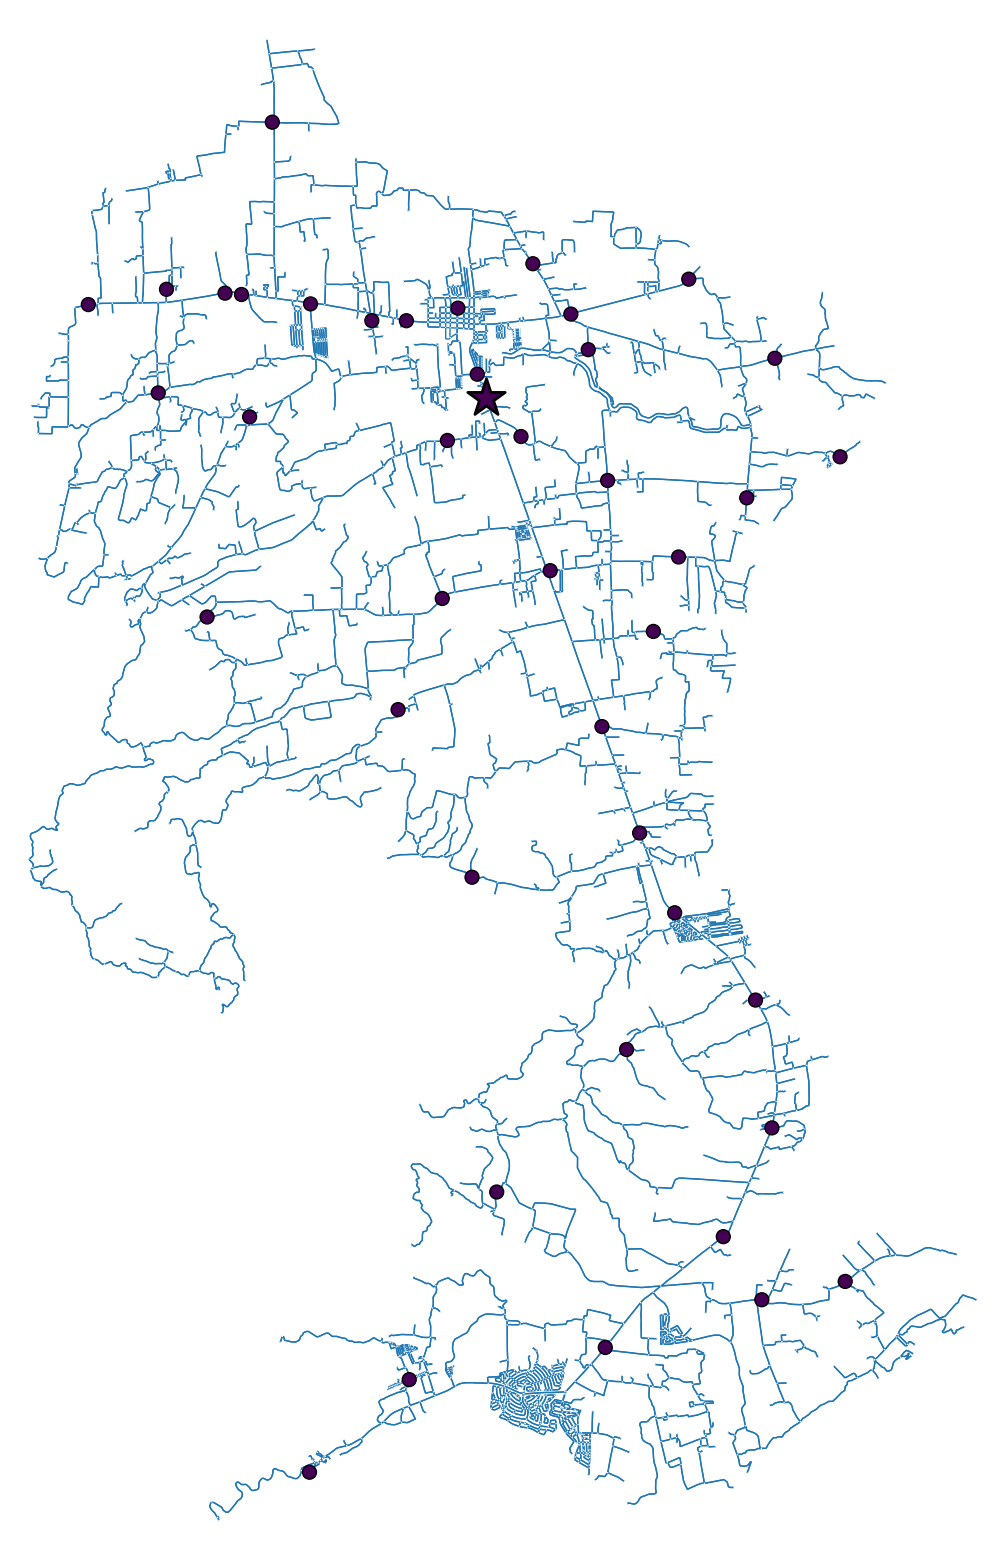

,vaccination_center,distance
Village_name,,
Abung,Don Leon Mercado Sr. MNHS,5390.98
Balagbag,Don Leon Mercado Sr. MNHS,2763.147
Barualte,Don Leon Mercado Sr. MNHS,17369.661
Bataan,Don Leon Mercado Sr. MNHS,14675.868
Buhay Na Sapa,Don Leon Mercado Sr. MNHS,2813.985
Bulsa,Don Leon Mercado Sr. MNHS,15494.686
Calicanto,Don Leon Mercado Sr. MNHS,3151.134
Calitcalit,Don Leon Mercado Sr. MNHS,2810.548
Calubcub I,Don Leon Mercado Sr. MNHS,7189.878


In [ ]:
## Load Data
# vacc = pd.read_excel('Vaccination_Centers_Table.xlsx')
# vill = pd.read_excel('Village_Centers_Table.xlsx')
vacc = pd.read_excel("/content/gdrive/MyDrive/Colab Notebooks/datasets/Vaccination_Centers_Table.xlsx")
vill = pd.read_excel("/content/gdrive/MyDrive/Colab Notebooks/datasets/Village_Centers_Table.xlsx")
#Set how many vaccination sites
L = 1

## Run enumerative algorithm and return village assignments, distance matrix, and ranking of all other suboptimal site combinations
assignment2, df_distances, results2 = optimal_sites(L = 1 , vaccination_centers_df = vacc, villages_df = vill,
                        graph_area = ("San Juan, Batangas, Philippines"), return_ranking = True, enumerative = True,
                        distance = "road", return_distances = True, plot = True)

assignment2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


phase 1 complete,  distance matrix computed
phase 2 complete, optimization finished


<ipython-input-6-774dd8a646ee>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  optimal_sites_loc["colors"] = optimal_sites_loc["Name"].astype('category').cat.codes


<Figure size 37500x25500 with 0 Axes>

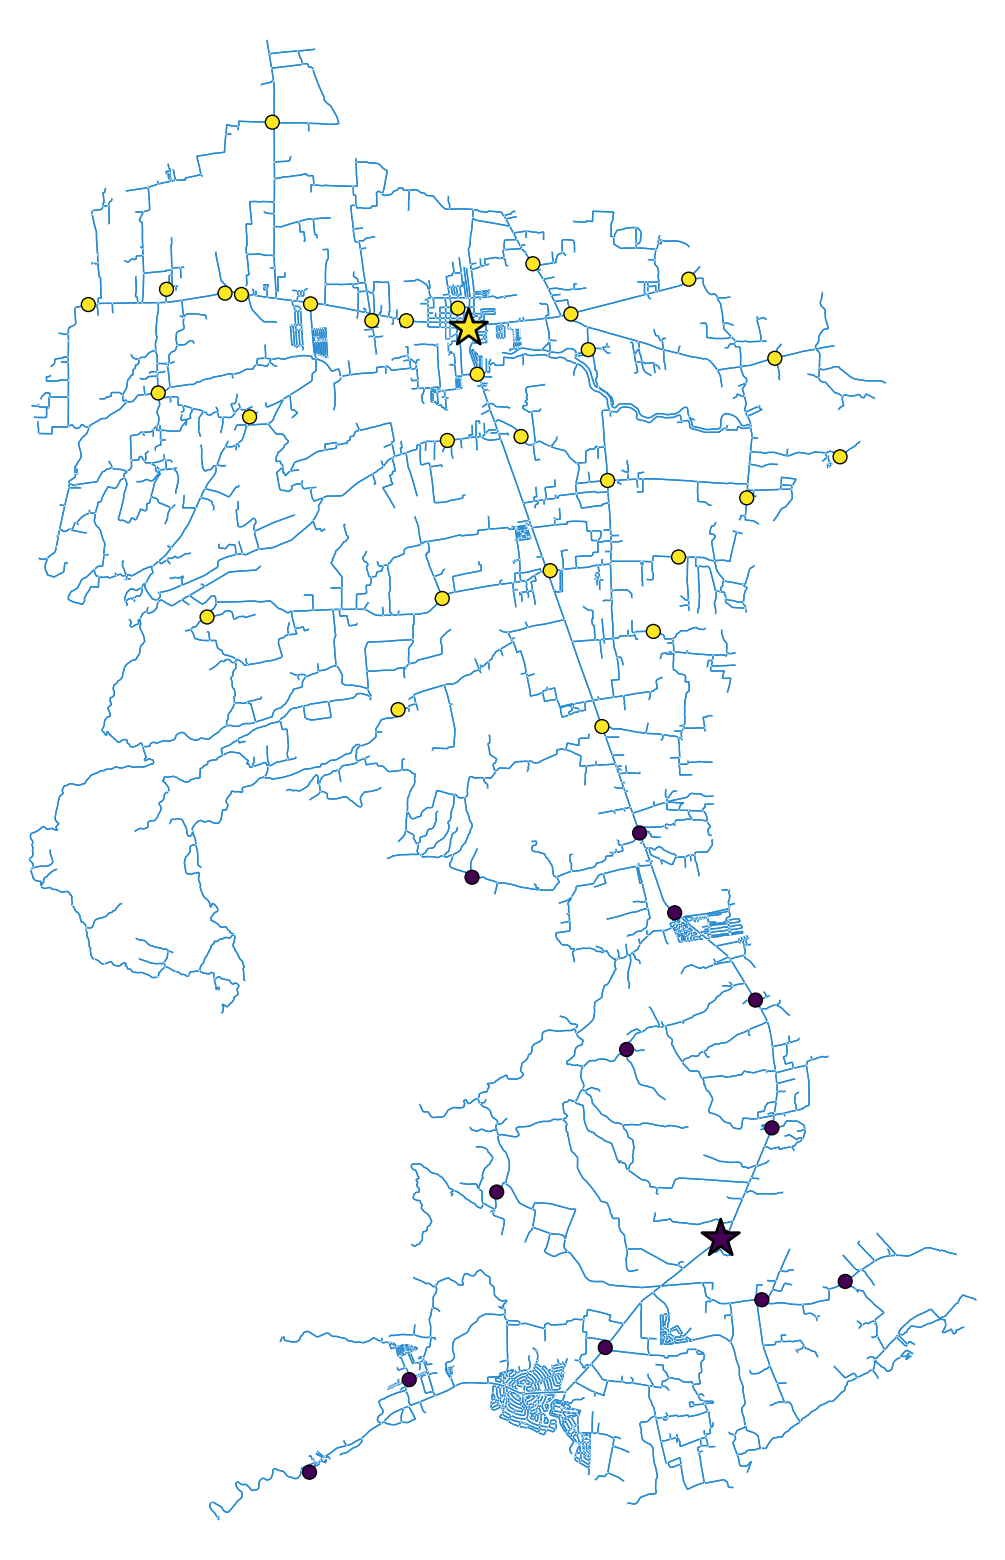

,vaccination_center,distance
Village_name,,
Abung,San Juan Rural Health Unit I,6692.135
Balagbag,San Juan Rural Health Unit I,4064.302
Barualte,Paaralang Elementarya ng Bataan,2693.793
Bataan,Paaralang Elementarya ng Bataan,0
Buhay Na Sapa,San Juan Rural Health Unit I,4115.14
Bulsa,Paaralang Elementarya ng Bataan,4552.727
Calicanto,San Juan Rural Health Unit I,1857.728
Calitcalit,San Juan Rural Health Unit I,1684.927
Calubcub I,Paaralang Elementarya ng Bataan,7485.99


In [ ]:
## Load Data
# vacc = pd.read_excel('Vaccination_Centers_Table.xlsx')
# vill = pd.read_excel('Village_Centers_Table.xlsx')
vacc = pd.read_excel("/content/gdrive/MyDrive/Colab Notebooks/datasets/Vaccination_Centers_Table.xlsx")
vill = pd.read_excel("/content/gdrive/MyDrive/Colab Notebooks/datasets/Village_Centers_Table.xlsx")
#Set how many vaccination sites
L = 2

## Run enumerative algorithm and return village assignments, distance matrix, and ranking of all other suboptimal site combinations
assignment2, df_distances, results2 = optimal_sites(L = L, vaccination_centers_df = vacc, villages_df = vill,
                        graph_area = ("San Juan, Batangas, Philippines"), return_ranking = True, enumerative = True,
                        distance = "road", return_distances = True, plot = True)

assignment2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


phase 1 complete,  distance matrix computed
phase 2 complete, optimization finished


<ipython-input-6-774dd8a646ee>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  optimal_sites_loc["colors"] = optimal_sites_loc["Name"].astype('category').cat.codes


<Figure size 37500x25500 with 0 Axes>

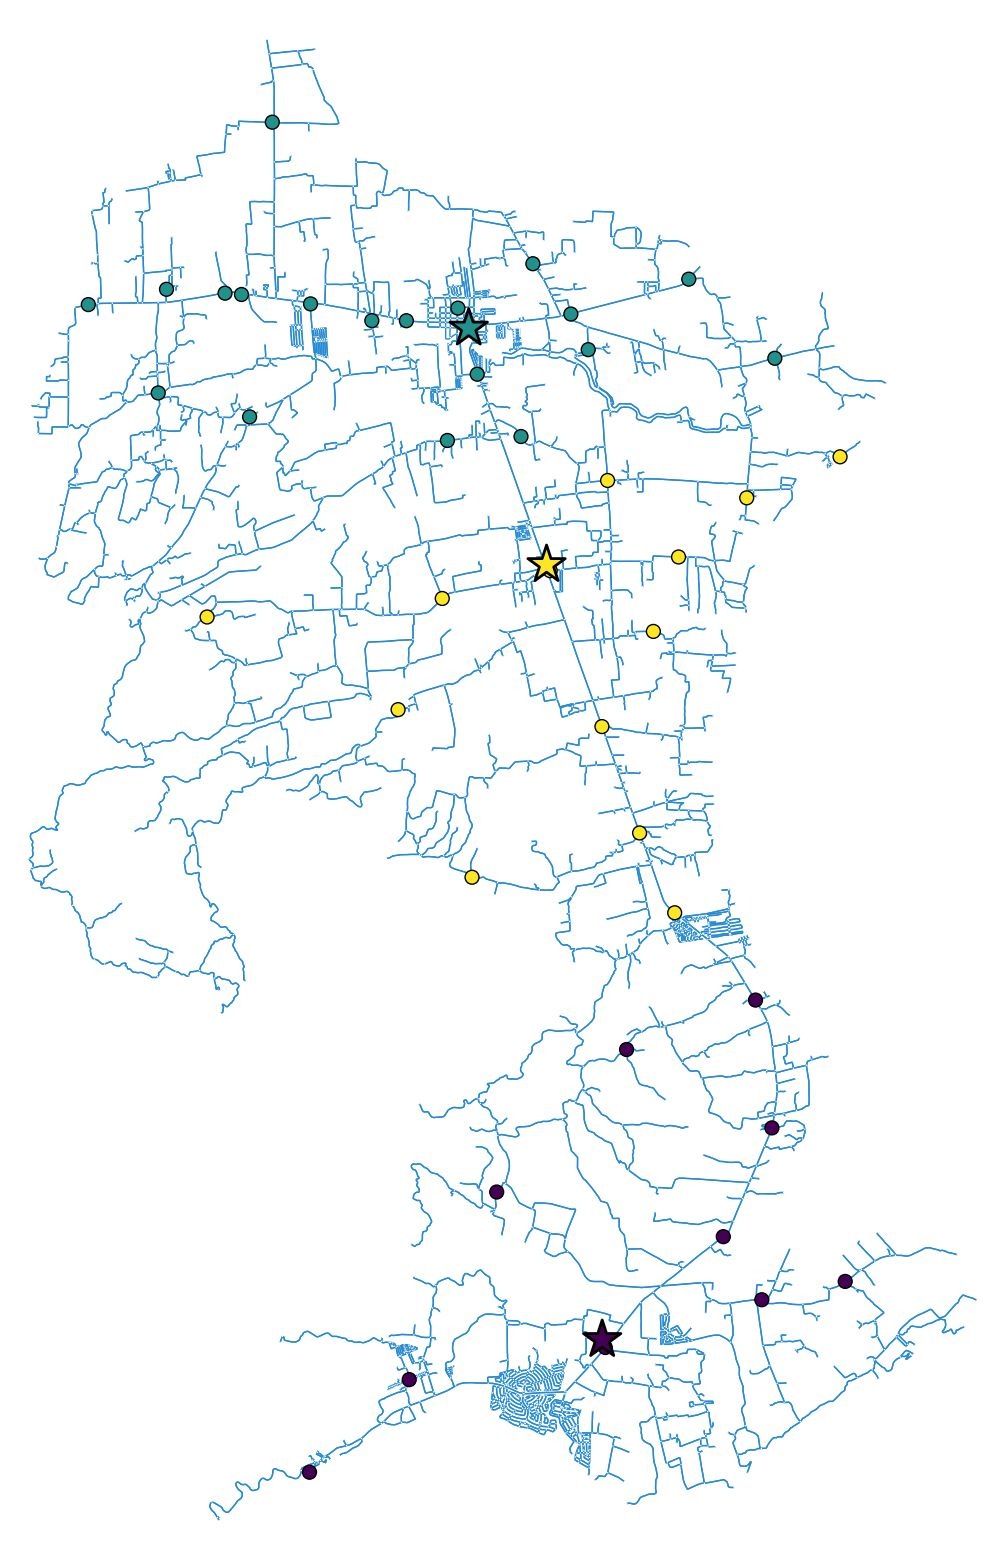

,vaccination_center,distance
Village_name,,
Abung,San Juan Rural Health Unit II,2576.995
Balagbag,San Juan Rural Health Unit II,2314.882
Barualte,Laiya Elementary School,2878.228
Bataan,Laiya Elementary School,2182.725
Buhay Na Sapa,San Juan Rural Health Unit II,0
Bulsa,Laiya Elementary School,4737.162
Calicanto,San Juan Rural Health Unit I,1857.728
Calitcalit,San Juan Rural Health Unit I,1684.927
Calubcub I,San Juan Rural Health Unit II,4375.893


In [ ]:
## Load Data
# vacc = pd.read_excel('Vaccination_Centers_Table.xlsx')
# vill = pd.read_excel('Village_Centers_Table.xlsx')
vacc = pd.read_excel("/content/gdrive/MyDrive/Colab Notebooks/datasets/Vaccination_Centers_Table.xlsx")
vill = pd.read_excel("/content/gdrive/MyDrive/Colab Notebooks/datasets/Village_Centers_Table.xlsx")
#Set how many vaccination sites
L = 3

## Run enumerative algorithm and return village assignments, distance matrix, and ranking of all other suboptimal site combinations
assignment2, df_distances, results2 = optimal_sites(L = L, vaccination_centers_df = vacc, villages_df = vill,
                        graph_area = ("San Juan, Batangas, Philippines"), return_ranking = True, enumerative = True,
                        distance = "road", return_distances = True, plot = True)

assignment2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


phase 1 complete,  distance matrix computed
 The best solution found:
 [ 0. 58.  1. 23.]

 Objective function:
 4997.09069677659


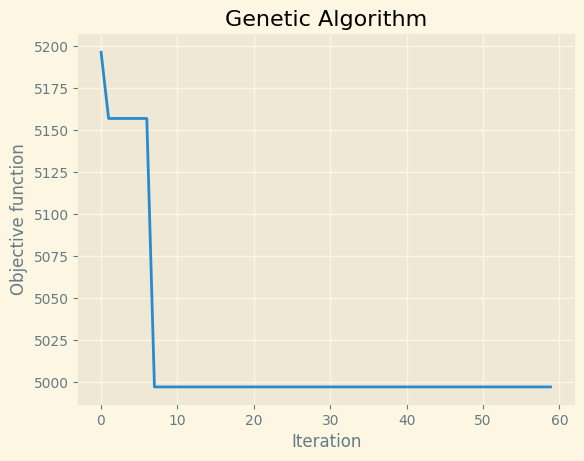

<ipython-input-6-774dd8a646ee>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  optimal_sites_loc["colors"] = optimal_sites_loc["Name"].astype('category').cat.codes


<Figure size 37500x25500 with 0 Axes>

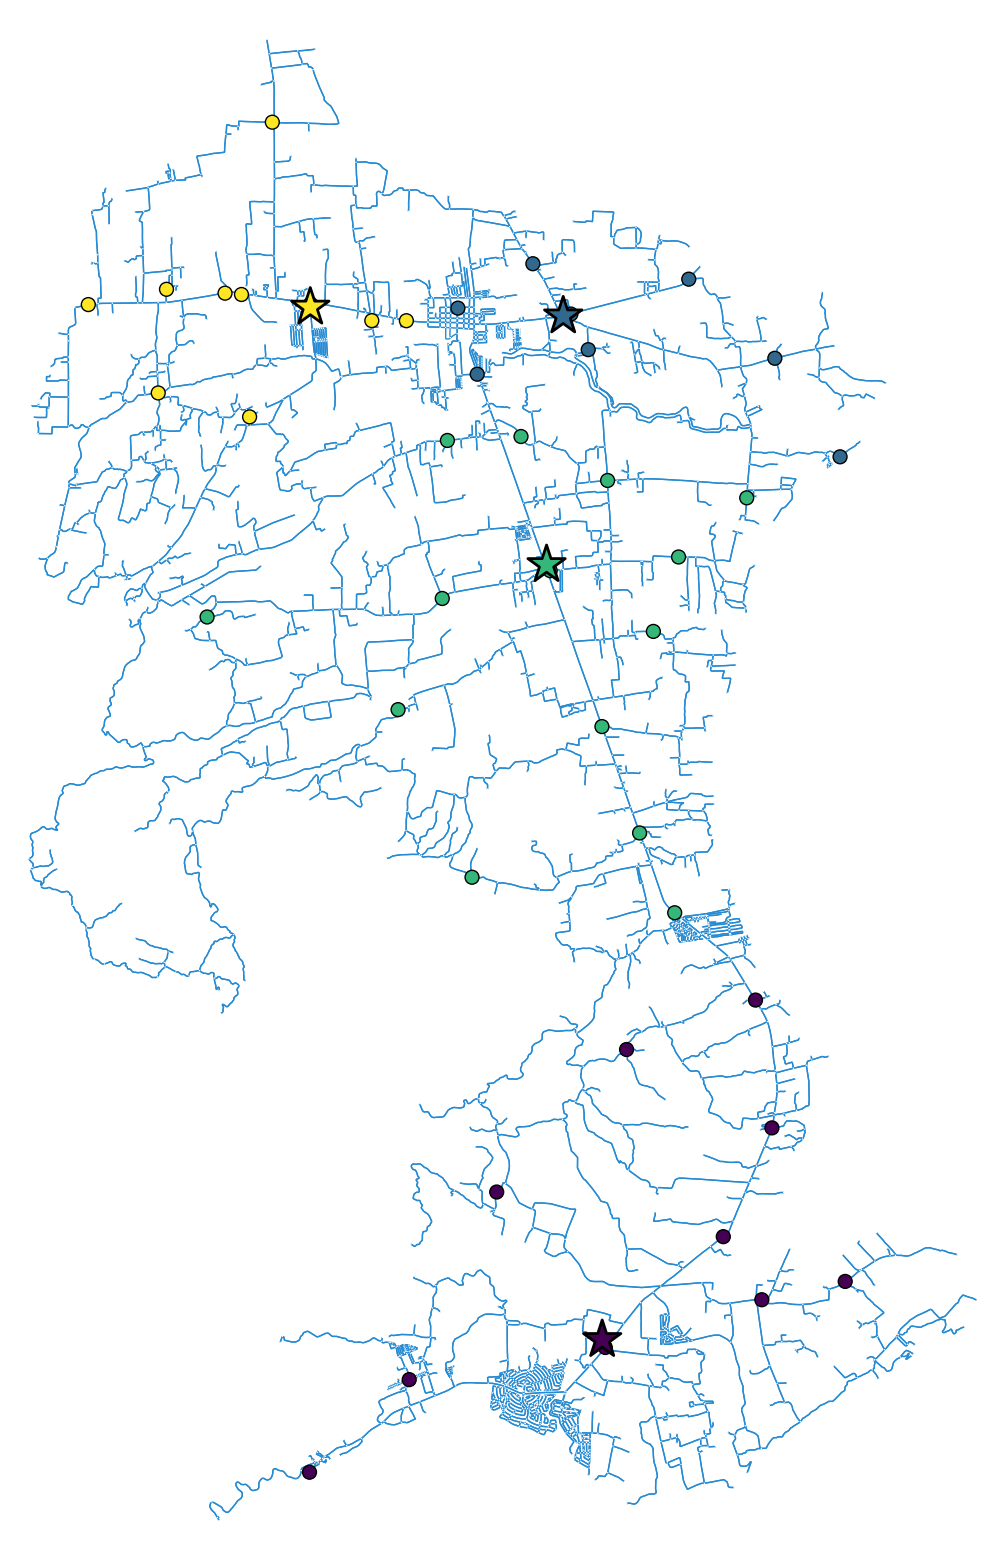

,vaccination_center,distance
Village_name,,
Abung,San Juan Rural Health Unit II,2576.995
Balagbag,San Juan Rural Health Unit II,2314.882
Barualte,Laiya Elementary School,2878.228
Bataan,Laiya Elementary School,2182.725
Buhay Na Sapa,San Juan Rural Health Unit II,0
Bulsa,Laiya Elementary School,4737.162
Calicanto,Sico 1.0 National High School,1176.926
Calitcalit,"San Juan Doctors Hospital, Inc.",143.837
Calubcub I,San Juan Rural Health Unit II,4375.893


In [ ]:
## Load Data
vacc = pd.read_excel("/content/gdrive/MyDrive/Colab Notebooks/datasets/Vaccination_Centers_Table.xlsx")
vill = pd.read_excel("/content/gdrive/MyDrive/Colab Notebooks/datasets/Village_Centers_Table.xlsx")

#Set how many vaccination sites
L = 4

## Run genetic algorithm and return village assignments for higher L

assignment4 = optimal_sites(L = L, vaccination_centers_df = vacc, villages_df = vill,
                        graph_area = ("San Juan, Batangas, Philippines"))

assignment4

In [ ]:
mean_distance = assignment2['distance'].mean()
print(f"Mean Distance: {mean_distance} kilometers")

Mean Distance: 3695.134119047619 kilometers


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


phase 1 complete,  distance matrix computed
 The best solution found:
 [14.  1. 58. 23.  0.]

 Objective function:
 4361.396823651877


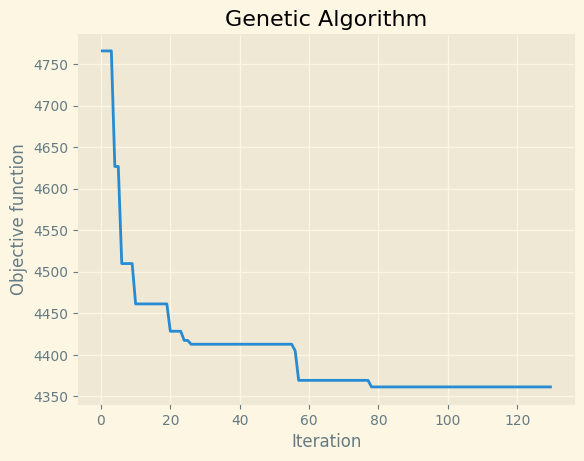

<ipython-input-6-774dd8a646ee>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  optimal_sites_loc["colors"] = optimal_sites_loc["Name"].astype('category').cat.codes


<Figure size 37500x25500 with 0 Axes>

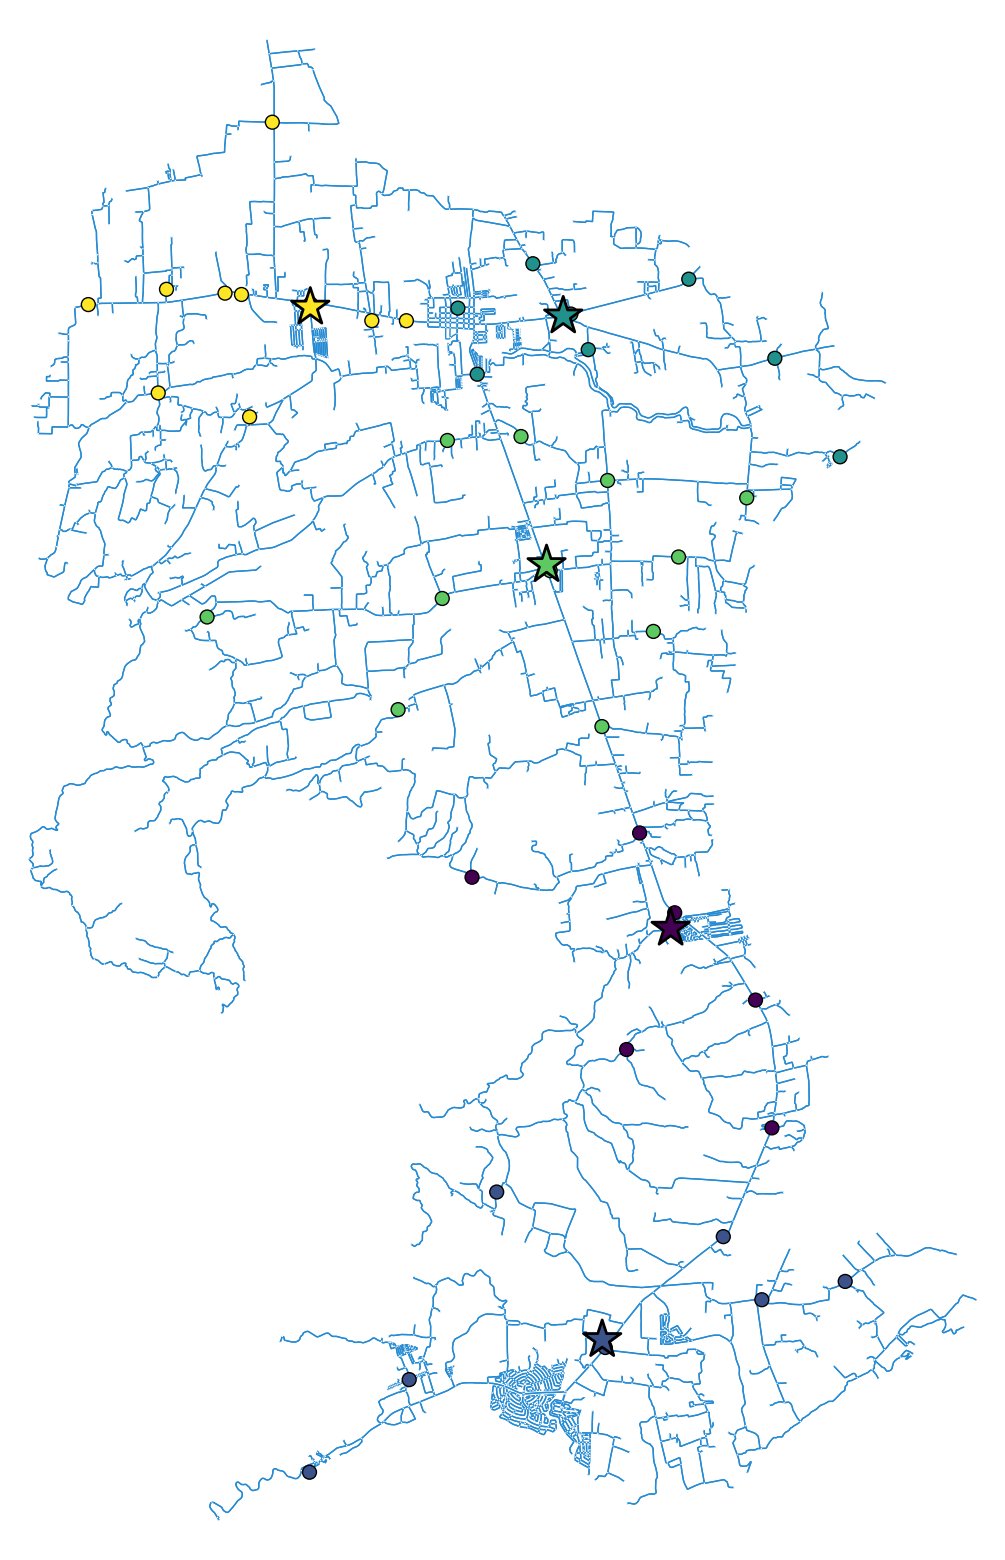

,vaccination_center,distance
Village_name,,
Abung,San Juan Rural Health Unit II,2576.995
Balagbag,San Juan Rural Health Unit II,2314.882
Barualte,Laiya Elementary School,2878.228
Bataan,Laiya Elementary School,2182.725
Buhay Na Sapa,San Juan Rural Health Unit II,0
Bulsa,Laiya Elementary School,4737.162
Calicanto,Sico 1.0 National High School,1176.926
Calitcalit,"San Juan Doctors Hospital, Inc.",143.837
Calubcub I,Calubcub II Elementary School,1707.725


In [ ]:
## Load Data
vacc = pd.read_excel("/content/gdrive/MyDrive/Colab Notebooks/datasets/Vaccination_Centers_Table.xlsx")
vill = pd.read_excel("/content/gdrive/MyDrive/Colab Notebooks/datasets/Village_Centers_Table.xlsx")

#Set how many vaccination sites
L = 5

## Run genetic algorithm and return village assignments for higher L

assignment4 = optimal_sites(L = L, vaccination_centers_df = vacc, villages_df = vill,
                        graph_area = ("San Juan, Batangas, Philippines"))

assignment4

In [ ]:
vacc = pd.read_excel("/content/gdrive/MyDrive/Colab Notebooks/datasets/Vaccination_Centers_Table.xlsx")
vill = pd.read_excel("/content/gdrive/MyDrive/Colab Notebooks/datasets/Village_Centers_Table.xlsx")
display(vacc)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,latitude,longitude,Name
0,13.791348,121.407575,San Juan Rural Health Unit II
1,13.826496,121.409996,"San Juan Doctors Hospital, Inc."
2,13.824779,121.396247,San Juan Rural Health Unit I
3,13.829028,121.367354,Divine Care Hospital Multi Services Corp.
4,13.809593,121.400683,San Juan District Hospital
...,...,...,...
60,13.831262,121.396933,San Juan Senior High School
61,13.827714,121.394403,Joseph Marello Institute
62,13.829072,121.395489,Batangas Eastern Colleges
63,13.802321,121.403336,Batangas State University - San Juan Campus


In [ ]:
display(vill)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,infected,population,latitude,longitude,Village_name
0,14,2444,13.768463,121.415633,Abung
1,7,2929,13.803248,121.416456,Balagbag
2,2,1933,13.687448,121.438898,Barualte
3,3,2204,13.696362,121.433293,Bataan
4,26,5909,13.790502,121.408104,Buhay Na Sapa
5,3,2492,13.702674,121.400318,Bulsa
6,13,2257,13.825840,121.382144,Calicanto
7,59,5255,13.826772,121.411111,Calitcalit
8,13,2545,13.753426,121.421113,Calubcub I
9,9,4071,13.742145,121.426220,Calubcub II
